# –ü—ñ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–æ –≤–∏–∫–æ–Ω–∞–Ω–Ω—è –ø—Ä–æ–µ–∫—Ç—É

In [5]:
import zipfile

with zipfile.ZipFile('Animals-10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animals10')

### 1. –ü–µ—Ä–µ–≤—ñ—Ä–∫–∞ —Å—Ç—Ä—É–∫—Ç—É—Ä–∏ —Ç–∞ –ø—ñ–¥–≥–æ—Ç–æ–≤–∫–∞ —Å–µ—Ä–µ–¥–æ–≤–∏—â–∞

In [6]:
import os
from pathlib import Path

dataset_path = Path('/content/animals10/raw-img')

# Dictionary for class translation: Italian ‚Üí English
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}

classes = sorted([folder.name for folder in dataset_path.iterdir() if folder.is_dir()])
translated_classes = [translate[cls] for cls in classes]
print("Classes:", translated_classes)

Classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


### 2. –ü—ñ–¥—Ä–∞—Ö—É–Ω–æ–∫ –∑–æ–±—Ä–∞–∂–µ–Ω—å —É –∫–æ–∂–Ω–æ–º—É –∫–ª–∞—Å—ñ

In [7]:
for cls in classes:
    img_count = len(list((dataset_path / cls).glob('*')))
    print(f"{translate[cls]}: {img_count} images")

dog: 4863 images
horse: 2623 images
elephant: 1446 images
butterfly: 2112 images
chicken: 3098 images
cat: 1668 images
cow: 1866 images
sheep: 1820 images
spider: 4821 images
squirrel: 1862 images


### 3. –†–æ–∑–¥—ñ–ª–µ–Ω–Ω—è –Ω–∞ train / val / test

In [8]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil

def prepare_splits(base_dir, output_dir, val_ratio=0.15, test_ratio=0.15):
    base_dir = Path(base_dir)
    output_dir = Path(output_dir)

    # Create output folders with translated names
    for split in ['train', 'val', 'test']:
        for it_name, en_name in translate.items():
            (output_dir / split / en_name).mkdir(parents=True, exist_ok=True)

    # Process each Italian class
    for it_name, en_name in translate.items():
        source_folder = base_dir / it_name
        if not source_folder.exists():
            print(f"Source folder not found for class '{it_name}'")
            continue

        images = list(source_folder.glob('*'))

        if len(images) == 0:
            print(f"No images found for class '{it_name}'")
            continue

        # Step 3: Split into train, val, test
        train_imgs, temp_imgs = train_test_split(
            images, test_size=val_ratio + test_ratio, random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs, test_size=test_ratio / (val_ratio + test_ratio), random_state=42
        )

        # Step 4: Copy images to destination folders (translated names)
        for img in train_imgs:
            shutil.copy(img, output_dir / 'train' / en_name / img.name)
        for img in val_imgs:
            shutil.copy(img, output_dir / 'val' / en_name / img.name)
        for img in test_imgs:
            shutil.copy(img, output_dir / 'test' / en_name / img.name)

        print(f"Processed '{it_name}' ‚Üí '{en_name}': "
              f"{len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

    print("Dataset successfully split and translated.")

prepare_splits('/content/animals10/raw-img', '/content/dataset_split')


Processed 'cane' ‚Üí 'dog': 3404 train, 729 val, 730 test
Processed 'cavallo' ‚Üí 'horse': 1836 train, 393 val, 394 test
Processed 'elefante' ‚Üí 'elephant': 1012 train, 217 val, 217 test
Processed 'farfalla' ‚Üí 'butterfly': 1478 train, 317 val, 317 test
Processed 'gallina' ‚Üí 'chicken': 2168 train, 465 val, 465 test
Processed 'gatto' ‚Üí 'cat': 1167 train, 250 val, 251 test
Processed 'mucca' ‚Üí 'cow': 1306 train, 280 val, 280 test
Processed 'pecora' ‚Üí 'sheep': 1274 train, 273 val, 273 test
Processed 'ragno' ‚Üí 'spider': 3374 train, 723 val, 724 test
Processed 'scoiattolo' ‚Üí 'squirrel': 1303 train, 279 val, 280 test
Dataset successfully split and translated.


### 4. –§–æ—Ä–º–∞—Ç —Ñ–∞–π–ª—ñ–≤

In [9]:
import PIL

example = list((dataset_path / classes[0]).glob('*'))[0]
img = PIL.Image.open(example)
print("Size:", img.size)
print("Format:", img.format)
img.show()

Size: (300, 225)
Format: JPEG


### 5. –ü–µ—Ä–µ—Ç–≤–æ—Ä–µ–Ω–Ω—è –∑–æ–±—Ä–∞–∂–µ–Ω—å —É —Ç–µ–Ω–∑–æ—Ä–∏ + –∞—É–≥–º–µ–Ω—Ç–∞—Ü—ñ—è

In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformation pipeline for training set with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize all images to 128x128
    transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally
    transforms.RandomRotation(10),             # Random rotation up to ¬±10 degrees
    transforms.ToTensor(),                     # Convert PIL Image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])          # Normalize pixel values to range [-1, 1]
])

# Define transformation pipeline for validation and test sets (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize images
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize([0.5], [0.5])          # Normalize
])

# Load the datasets using ImageFolder
train_dataset = ImageFolder('/content/dataset_split/train', transform=transform_train)
val_dataset = ImageFolder('/content/dataset_split/val', transform=transform_test)
test_dataset = ImageFolder('/content/dataset_split/test', transform=transform_test)


### 6. DataLoader

In [11]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


### 7. –í—ñ–∑—É–∞–ª—ñ–∑–∞—Ü—ñ—è –∑–æ–±—Ä–∞–∂–µ–Ω—å –∑ –∫–ª–∞—Å–∞–º–∏

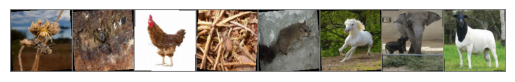

Labels: ['spider', 'spider', 'chicken', 'spider', 'squirrel', 'horse', 'elephant', 'sheep']


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to denormalize and display a batch of images
def imshow(img):
    img = img / 2 + 0.5            # Denormalize (reverse normalization)
    npimg = img.numpy()           # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Change channel order for display
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 8 images from the batch
imshow(torchvision.utils.make_grid(images[:8]))

print('Labels:', [train_dataset.classes[label] for label in labels[:8]])


### 8. –ì—ñ—Å—Ç–æ–≥—Ä–∞–º–∞ —Ä–æ–∑–ø–æ–¥—ñ–ª—É –∫–ª–∞—Å—ñ–≤

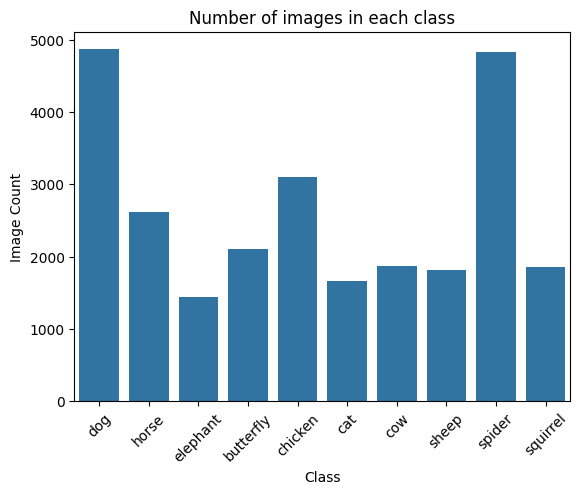

In [13]:
import seaborn as sns
import pandas as pd

# List to store image counts per class
counts = []

for cls in classes:
    num = len(list((dataset_path / cls).glob('*')))
    translated_name = translate[cls]  # Translate class name to English
    counts.append({'class': translated_name, 'count': num})

# Create DataFrame for plotting
df = pd.DataFrame(counts)

# Plot class distribution as a bar chart
sns.barplot(data=df, x='class', y='count')
plt.xticks(rotation=45)
plt.title("Number of images in each class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.show()


### –ü–ª–∞–Ω—É–≤–∞–Ω–Ω—è –Ω–∞—Å—Ç—É–ø–Ω–æ–≥–æ –µ—Ç–∞–ø—É:

**–ú–µ—Ç—Ä–∏–∫–∏ –µ—Ñ–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç—ñ –º–æ–¥–µ–ª—ñ:**

*   Accuracy ‚Äî —á–∞—Å—Ç–∫–∞ –ø—Ä–∞–≤–∏–ª—å–Ω–∏—Ö –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω—å;
*   Precision ‚Äî —Ç–æ—á–Ω—ñ—Å—Ç—å –ø–µ—Ä–µ–¥–±–∞—á–µ–Ω—å –¥–ª—è –∫–æ–∂–Ω–æ–≥–æ –∫–ª–∞—Å—É;
*   Recall ‚Äî –ø–æ–≤–Ω–æ—Ç–∞ –≤–∏—è–≤–ª–µ–Ω–Ω—è –ø—Ä–∞–≤–∏–ª—å–Ω–∏—Ö –æ–±‚Äô—î–∫—Ç—ñ–≤;
*   F1-score ‚Äî –±–∞–ª–∞–Ω—Å –º—ñ–∂ precision —ñ recall;
*   Confusion matrix ‚Äî –ø–æ–∫–∞–∂–µ, —â–æ –∑ —á–∏–º –º–æ–¥–µ–ª—å –ø–ª—É—Ç–∞—î.

**–ó–∞–ø–ª–∞–Ω–æ–≤–∞–Ω–∞ –∞—Ä—Ö—ñ—Ç–µ–∫—Ç—É—Ä–∞ –Ω–µ–π—Ä–æ–Ω–Ω–æ—ó –º–µ—Ä–µ–∂—ñ:**

*   –ö—ñ–ª—å–∫—ñ—Å—Ç—å –∑–≥–æ—Ä—Ç–∫–æ–≤–∏—Ö —à–∞—Ä—ñ–≤: 2‚Äì3;
*   –ö—ñ–ª—å–∫—ñ—Å—Ç—å —Ñ—ñ–ª—å—Ç—Ä—ñ–≤: 32 ‚Üí 64 ‚Üí 128;
*   –ê–∫—Ç–∏–≤–∞—Ü—ñ—è: ReLU –ø—ñ—Å–ª—è –∫–æ–∂–Ω–æ–≥–æ –∑–≥–æ—Ä—Ç–∫–æ–≤–æ–≥–æ —à–∞—Ä—É;
*   Pooling: MaxPooling2D –ø—ñ—Å–ª—è –∫–æ–∂–Ω–æ–≥–æ –¥—Ä—É–≥–æ–≥–æ —à–∞—Ä—É;
*   Dropout: 0.3‚Äì0.5 –¥–ª—è –∑–∞–ø–æ–±—ñ–≥–∞–Ω–Ω—è –ø–µ—Ä–µ–Ω–∞–≤—á–∞–Ω–Ω—é;
*   Flatten –ø—ñ—Å–ª—è –∑–≥–æ—Ä—Ç–æ–∫ —ñ pooling;
*   –ö—ñ–ª—å–∫—ñ—Å—Ç—å –ø–æ–≤–Ω–æ–∑–≤‚Äô—è–∑–∞–Ω–∏—Ö —à–∞—Ä—ñ–≤: 1‚Äì2 (–Ω–∞–ø—Ä–∏–∫–ª–∞–¥: 256 ‚Üí 10);
*   –§—ñ–Ω–∞–ª—å–Ω–∞ –∞–∫—Ç–∏–≤–∞—Ü—ñ—è: Softmax;
*   –û–ø—Ç–∏–º—ñ–∑–∞—Ç–æ—Ä: Adam;
*   –§—É–Ω–∫—Ü—ñ—è –≤—Ç—Ä–∞—Ç: CrossEntropyLoss (–±–∞–≥–∞—Ç–æ–∫–ª–∞—Å–æ–≤–∞ –∫–ª–∞—Å–∏—Ñ—ñ–∫–∞—Ü—ñ—è).

# –ü–æ–±—É–¥–æ–≤–∞ –±–∞–∑–æ–≤–æ—ó –º–æ–¥–µ–ª—ñ –Ω–µ–π—Ä–æ–Ω–Ω–æ—ó –º–µ—Ä–µ–∂—ñ

### üß© –†–µ–∞–ª—ñ–∑–∞—Ü—ñ—è –ø—Ä–æ—Å—Ç–æ—ó –∞—Ä—Ö—ñ—Ç–µ–∫—Ç—É—Ä–∏ CNN

#### üß± –û—Å–Ω–æ–≤–Ω—ñ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç–∏:
- **3 –∑–≥–æ—Ä—Ç–∫–æ–≤–∏—Ö —à–∞—Ä–∏ (Conv2D)**:
  - –ö–æ–∂–µ–Ω –º–∞—î —è–¥—Ä–æ 3x3, padding=1 (—â–æ–± –∑–±–µ—Ä—ñ–≥–∞—Ç–∏ —Ä–æ–∑–º—ñ—Ä –∑–æ–±—Ä–∞–∂–µ–Ω–Ω—è).
  - –ö—ñ–ª—å–∫—ñ—Å—Ç—å —Ñ—ñ–ª—å—Ç—Ä—ñ–≤: 32 ‚Üí 64 ‚Üí 128.
- **ReLU**: –∞–∫—Ç–∏–≤–∞—Ü—ñ–π–Ω–∞ —Ñ—É–Ω–∫—Ü—ñ—è –ø—ñ—Å–ª—è –∫–æ–∂–Ω–æ—ó –∑–≥–æ—Ä—Ç–∫–∏.
- **MaxPooling2D**: –∑–º–µ–Ω—à—É—î –ø—Ä–æ—Å—Ç–æ—Ä–æ–≤—ñ —Ä–æ–∑–º—ñ—Ä–∏ (–ø—ñ—Å–ª—è –∫–æ–∂–Ω–æ–≥–æ –∑–≥–æ—Ä—Ç–∫–æ–≤–æ–≥–æ –±–ª–æ–∫—É).
- **Flatten**: –ø–µ—Ä–µ—Ç–≤–æ—Ä—é—î 3D-–≤–∏—Ö—ñ–¥ —É –≤–µ–∫—Ç–æ—Ä –¥–ª—è –ø–æ–≤–Ω–æ–∑–≤‚Äô—è–∑–∞–Ω–∏—Ö —à–∞—Ä—ñ–≤.
- **Dense (Linear) —à–∞—Ä–∏**:
  - –û–¥–∏–Ω –ø—Ä–∏—Ö–æ–≤–∞–Ω–∏–π —à–∞—Ä –Ω–∞ 256 –Ω–µ–π—Ä–æ–Ω—ñ–≤ + Dropout(0.5)
  - –í–∏—Ö—ñ–¥–Ω–∏–π —à–∞—Ä –Ω–∞ 10 –Ω–µ–π—Ä–æ–Ω—ñ–≤ (–∑–∞ –∫—ñ–ª—å–∫—ñ—Å—Ç—é –∫–ª–∞—Å—ñ–≤)
- **Softmax –Ω–µ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—î—Ç—å—Å—è —è–≤–Ω–æ**, –±–æ —Ñ—É–Ω–∫—Ü—ñ—è –≤—Ç—Ä–∞—Ç `CrossEntropyLoss` –≤–∫–ª—é—á–∞—î –π–æ–≥–æ –∞–≤—Ç–æ–º–∞—Ç–∏—á–Ω–æ.

–ú–æ–¥–µ–ª—å –ª–µ–≥–∫–æ –∞–¥–∞–ø—Ç—É–≤–∞—Ç–∏ –¥–æ —ñ–Ω—à–æ—ó –∫—ñ–ª—å–∫–æ—Å—Ç—ñ –∫–ª–∞—Å—ñ–≤ —á–µ—Ä–µ–∑ –ø–∞—Ä–∞–º–µ—Ç—Ä `num_classes`.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a basic Convolutional Neural Network
class AnimalCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AnimalCNN, self).__init__()

        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # padding=1 to preserve size
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size by half

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Input size depends on final feature map
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)  # Output layer: one unit per class

    def forward(self, x):
        # Pass through convolutional layers with ReLU and pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten feature map to feed into fully connected layers
        x = x.view(-1, 128 * 16 * 16)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Final output (no softmax needed if using CrossEntropyLoss)

        return x

# Create model and move to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AnimalCNN(num_classes=10).to(device)

print(model)


AnimalCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### ‚öôÔ∏è –ù–∞–ª–∞—à—Ç—É–≤–∞–Ω–Ω—è —Ñ—É–Ω–∫—Ü—ñ—ó –≤—Ç—Ä–∞—Ç —ñ –æ–ø—Ç–∏–º—ñ–∑–∞—Ç–æ—Ä–∞

#### üßÆ –§—É–Ω–∫—Ü—ñ—è –≤—Ç—Ä–∞—Ç:
- –í–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—î—Ç—å—Å—è **`CrossEntropyLoss`**, —è–∫–∞ –ø—ñ–¥—Ö–æ–¥–∏—Ç—å –¥–ª—è –∑–∞–¥–∞—á **–±–∞–≥–∞—Ç–æ–∫–ª–∞—Å–æ–≤–æ—ó –∫–ª–∞—Å–∏—Ñ—ñ–∫–∞—Ü—ñ—ó**.
- –í–æ–Ω–∞ **–∞–≤—Ç–æ–º–∞—Ç–∏—á–Ω–æ –≤–∫–ª—é—á–∞—î softmax**, —Ç–æ–º—É –≤ –º–æ–¥–µ–ª—ñ –π–æ–≥–æ –º–æ–∂–Ω–∞ –Ω–µ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É–≤–∞—Ç–∏ –æ–∫—Ä–µ–º–æ.

#### ‚öôÔ∏è –û–ø—Ç–∏–º—ñ–∑–∞—Ç–æ—Ä:
- –û–±—Ä–∞–Ω–æ **`Adam`** ‚Äî —Å—É—á–∞—Å–Ω–∏–π –æ–ø—Ç–∏–º—ñ–∑–∞—Ç–æ—Ä, —è–∫–∏–π –∞–¥–∞–ø—Ç—É—î —à–≤–∏–¥–∫—ñ—Å—Ç—å –Ω–∞–≤—á–∞–Ω–Ω—è –¥–ª—è –∫–æ–∂–Ω–æ–≥–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞.
- –ü–æ—á–∞—Ç–∫–æ–≤–∏–π learning rate –≤—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–æ –Ω–∞ **0.001**.

#### üìâ –ó–º–µ–Ω—à–µ–Ω–Ω—è learning rate (scheduler):
- –î–æ–¥–∞—Ç–∫–æ–≤–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—î—Ç—å—Å—è **`ReduceLROnPlateau`**, —è–∫–∏–π –∑–º–µ–Ω—à—É—î learning rate, —è–∫—â–æ **val_loss –Ω–µ –ø–æ–∫—Ä–∞—â—É—î—Ç—å—Å—è** –ø—Ä–æ—Ç—è–≥–æ–º –∫—ñ–ª—å–∫–æ—Ö –µ–ø–æ—Ö (–≤ –¥–∞–Ω–æ–º—É –≤–∏–ø–∞–¥–∫—É ‚Äî 3).
- –¶–µ –¥–æ–ø–æ–º–∞–≥–∞—î —É–Ω–∏–∫–∞—Ç–∏ ‚Äú–∑–∞—Å—Ç—Ä—è–≤–∞–Ω–Ω—è‚Äù –Ω–∞ –ø–ª–∞—Ç–æ.


In [17]:
import torch.optim as optim

# Define loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam) with learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Learning rate scheduler to reduce LR on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)


### üöÄ –¢—Ä–µ–Ω—É–≤–∞–Ω–Ω—è –º–æ–¥–µ–ª—ñ

#### üîß –ù–∞–ª–∞—à—Ç—É–≤–∞–Ω–Ω—è:
- **–ö—ñ–ª—å–∫—ñ—Å—Ç—å –µ–ø–æ—Ö**: 20
- **Batch size**: 32 (–≤—Å—Ç–∞–Ω–æ–≤–ª—é—î—Ç—å—Å—è —É DataLoader)
- **–§—É–Ω–∫—Ü—ñ—è –≤—Ç—Ä–∞—Ç**: CrossEntropyLoss
- **–û–ø—Ç–∏–º—ñ–∑–∞—Ç–æ—Ä**: Adam (lr=0.001)
- **–í–∞–ª—ñ–¥–∞—Ü—ñ–π–Ω–∞ –≤–∏–±—ñ—Ä–∫–∞**: –≤–∏–∫–æ—Ä–∏—Å—Ç–æ–≤—É—î—Ç—å—Å—è –¥–ª—è –æ—Ü—ñ–Ω–∫–∏ —è–∫–æ—Å—Ç—ñ –ø—ñ–¥ —á–∞—Å –Ω–∞–≤—á–∞–Ω–Ω—è

#### üìà –©–æ –±—É–¥–µ –≤–∏–≤–µ–¥–µ–Ω–æ:
- –ì—Ä–∞—Ñ—ñ–∫–∏ –∑–º—ñ–Ω–∏ **—Ç–æ—á–Ω–æ—Å—Ç—ñ** —Ç–∞ **–≤—Ç—Ä–∞—Ç** –Ω–∞ train/val –Ω–∞–±–æ—Ä–∞—Ö
- –§—ñ–Ω–∞–ª—å–Ω–∞ –∑–±–µ—Ä–µ–∂–µ–Ω–∞ –º–æ–¥–µ–ª—å –¥–ª—è –ø–æ–¥–∞–ª—å—à–æ–≥–æ –≤–∏–∫–æ—Ä–∏—Å—Ç–∞–Ω–Ω—è


–ö–æ–¥ —Ç—Ä–µ–Ω—É–≤–∞–Ω–Ω—è –º–æ–¥–µ–ª—ñ

In [18]:
import time
from sklearn.metrics import accuracy_score

num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Step the scheduler
    scheduler.step(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, "
          f"Time: {time.time() - start_time:.2f}s")


Epoch [1/20], Train Loss: 1.8730, Train Acc: 0.3358, Val Loss: 1.5602, Val Acc: 0.4753, Time: 69.48s
Epoch [2/20], Train Loss: 1.5237, Train Acc: 0.4824, Val Loss: 1.3599, Val Acc: 0.5415, Time: 67.55s
Epoch [3/20], Train Loss: 1.3606, Train Acc: 0.5397, Val Loss: 1.2085, Val Acc: 0.5991, Time: 67.74s
Epoch [4/20], Train Loss: 1.2549, Train Acc: 0.5723, Val Loss: 1.1464, Val Acc: 0.6144, Time: 66.46s
Epoch [5/20], Train Loss: 1.1827, Train Acc: 0.5986, Val Loss: 1.0876, Val Acc: 0.6416, Time: 67.35s
Epoch [6/20], Train Loss: 1.0996, Train Acc: 0.6252, Val Loss: 1.0663, Val Acc: 0.6498, Time: 67.60s
Epoch [7/20], Train Loss: 1.0573, Train Acc: 0.6380, Val Loss: 1.0397, Val Acc: 0.6513, Time: 67.00s
Epoch [8/20], Train Loss: 1.0100, Train Acc: 0.6527, Val Loss: 0.9931, Val Acc: 0.6689, Time: 67.36s
Epoch [9/20], Train Loss: 0.9566, Train Acc: 0.6702, Val Loss: 1.0077, Val Acc: 0.6607, Time: 66.79s
Epoch [10/20], Train Loss: 0.9263, Train Acc: 0.6811, Val Loss: 0.9347, Val Acc: 0.6933, Ti

–í—ñ–∑—É–∞–ª—ñ–∑–∞—Ü—ñ—è —Ç–æ—á–Ω–æ—Å—Ç—ñ —Ç–∞ –≤—Ç—Ä–∞—Ç

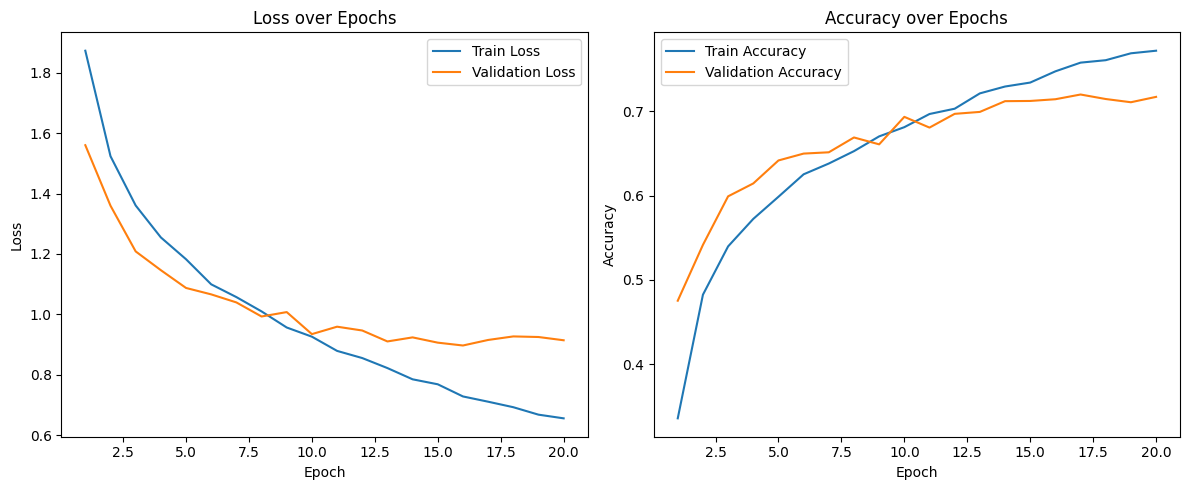

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


–ó–±–µ—Ä–µ–∂–µ–Ω–Ω—è –º–æ–¥–µ–ª—ñ

In [20]:
torch.save(model.state_dict(), 'animal_cnn_model.pth')
print("‚úÖ Model saved to animal_cnn_model.pth")

‚úÖ Model saved to animal_cnn_model.pth
